In [58]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [328]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
from config import CONFIG
home = os.path.join(os.path.expanduser('~'), "buni")

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 0
frame_idx = 30

scene_id = av2.get_log_ids()[scene_idx]
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)

points = Sweep.from_feather(frame_path).xyz

In [329]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import CONFIG

home = os.path.join(os.path.expanduser('~'), "buni")

# ge_path = os.path.join(home, "output-data", "av2", CONFIG['BBOX_EXPORT_DIR'])
ge_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['ROI'])


scene_id = os.listdir(ge_path)[scene_idx]
scene_path = os.path.join(ge_path, scene_id)

frame_id = os.listdir(scene_path)[frame_idx]
frame_path = os.path.join(ge_path, scene_id, frame_id)

In [330]:
scene_id, frame_id

('8223c3d0-3b08-3889-9cdc-a88592c4bd4a', '315974912559888000.feather')

In [331]:
bboxes_df = pd.read_feather(frame_path)
bboxes_df.head()

,box_center_x,box_center_y,box_length,box_width,ry
0,5.728041,-7.853813,11.434510,4.199797,2.967060
1,4.200444,-4.681949,1.307350,1.223873,1.134464
2,2.913793,-3.662703,4.685645,2.478366,0.872665
3,6.530048,-3.514411,5.720190,5.003826,1.047198
4,0.154044,1.829726,0.127414,0.032848,0.261799


In [332]:
from prototype_utils import bboxes_df_to_numpy_corners

bboxes_np = bboxes_df_to_numpy_corners(bboxes_df)

In [333]:
from prototype_utils import filter_roi

points_roi = filter_roi(points)

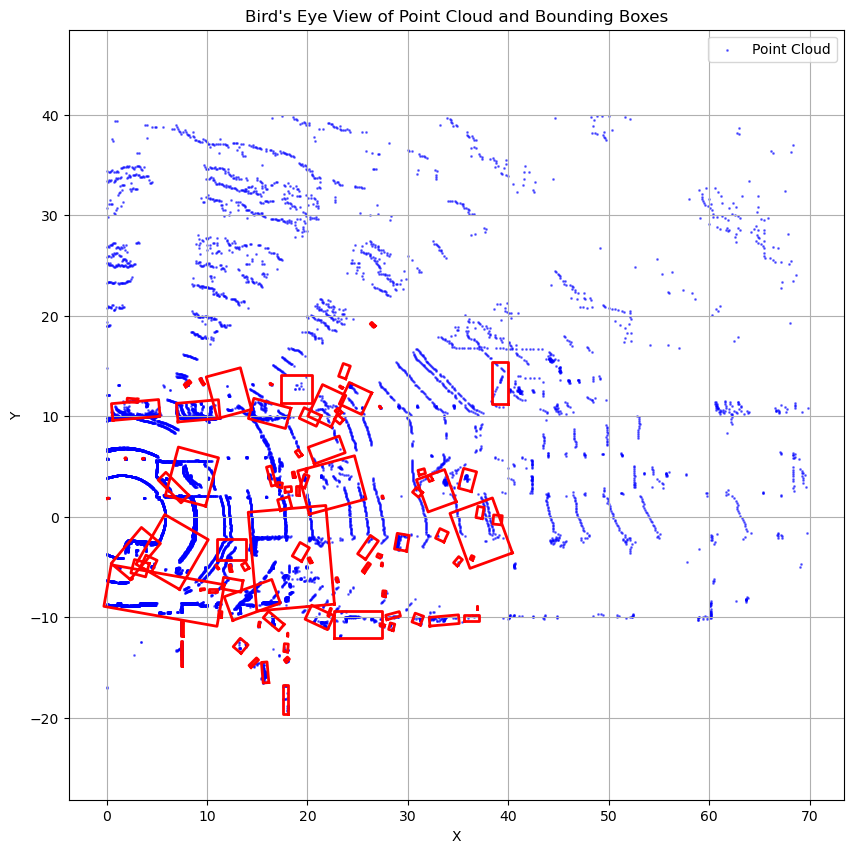

In [334]:
from prototype_utils import plot_point_cloud_and_bboxes

plot_point_cloud_and_bboxes(points_roi[:,:2], bboxes_np, fig_size=(10,10))

In [335]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def plot_point_cloud_and_bboxes_unique(points: np.ndarray, bboxes: np.ndarray, fig_size=(10, 10)):
    """
    Plots a 2D bird's eye view (BEV) of a point cloud and bounding boxes.

    Args:
        points (np.ndarray): A numpy array of shape (N, 2) representing the point cloud (x, y).
        bboxes (np.ndarray): A numpy array of shape (M, 4, 2) representing bounding boxes,
                             where each box is defined by 4 corners (x, y).
    """
    # Check input dimensions
    assert points.shape[1] == 2, "Points must have shape (N, 2)."
    assert bboxes.shape[1:] == (4, 2), "Bounding boxes must have shape (M, 4, 2)."

    plt.figure(figsize=fig_size)

    # Plot the point cloud
    plt.scatter(points[:, 0], points[:, 1], s=1, color='blue', label='Point Cloud', alpha=0.5)

    # Generate unique colors for each bounding box
    cmap = get_cmap('tab20')  # Use a colormap with distinct colors
    num_bboxes = bboxes.shape[0]
    colors = [cmap(i / num_bboxes) for i in range(num_bboxes)]

    # Plot each bounding box
    for i, bbox in enumerate(bboxes):
        bbox_closed = np.vstack([bbox, bbox[0]])  # Close the bounding box
        plt.plot(bbox_closed[:, 0], bbox_closed[:, 1], color=colors[i], linewidth=2, label=f'BBox {i + 1}' if i < 10 else None)

    # Add labels, legends, and grid
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View of Point Cloud and Bounding Boxes")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.axis('equal')  # Maintain aspect ratio
    plt.show()
    
# plot_point_cloud_and_bboxes_unique(points_roi[:,:2], bboxes_np, fig_size=(10,10))


In [336]:
bboxes_df['aspect_ratio'] = bboxes_df['box_width'] / bboxes_df['box_length']
bboxes_df['aspect_ratio']

bboxes_df['area'] = bboxes_df['box_width'] * bboxes_df['box_length']

In [337]:
bboxes_df.head()

,box_center_x,box_center_y,box_length,box_width,ry,aspect_ratio,area
0,5.728041,-7.853813,11.434510,4.199797,2.967060,0.367291,48.022616
1,4.200444,-4.681949,1.307350,1.223873,1.134464,0.936148,1.600030
2,2.913793,-3.662703,4.685645,2.478366,0.872665,0.528927,11.612743
3,6.530048,-3.514411,5.720190,5.003826,1.047198,0.874766,28.622836
4,0.154044,1.829726,0.127414,0.032848,0.261799,0.257809,0.004185


array([[<Axes: title={'center': 'aspect_ratio'}>]], dtype=object)

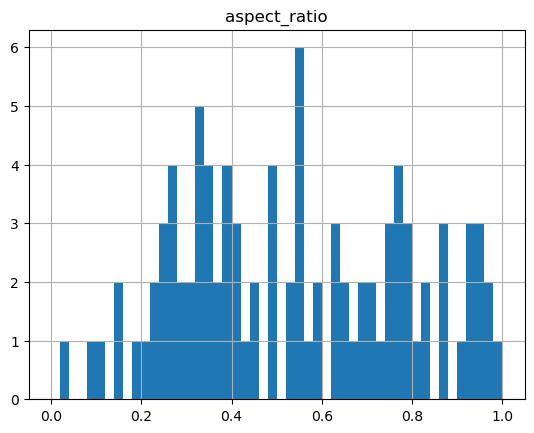

In [338]:
bboxes_df.hist(column='aspect_ratio', bins=50, range=(0, 1))

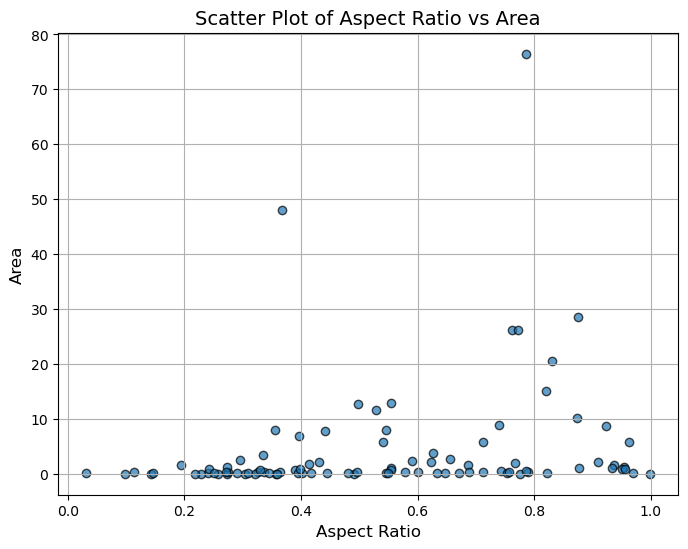

In [339]:
import matplotlib.pyplot as plt

def plot_aspect_ratio_vs_area(df, aspect_ratio_col, area_col, title="Scatter Plot of Aspect Ratio vs Area"):
    """
    Plots a scatter plot of aspect ratio vs area.

    Args:
        df (pd.DataFrame): The DataFrame containing aspect ratio and area.
        aspect_ratio_col (str): The column name for aspect ratios in the DataFrame.
        area_col (str): The column name for areas in the DataFrame.
        title (str): The title of the scatter plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df[aspect_ratio_col], df[area_col], alpha=0.7, edgecolor='k')
    plt.title(title, fontsize=14)
    plt.xlabel('Aspect Ratio', fontsize=12)
    plt.ylabel('Area', fontsize=12)
    plt.grid(True)
    plt.show()

# Example usage:
plot_aspect_ratio_vs_area(bboxes_df, 'aspect_ratio', 'area')


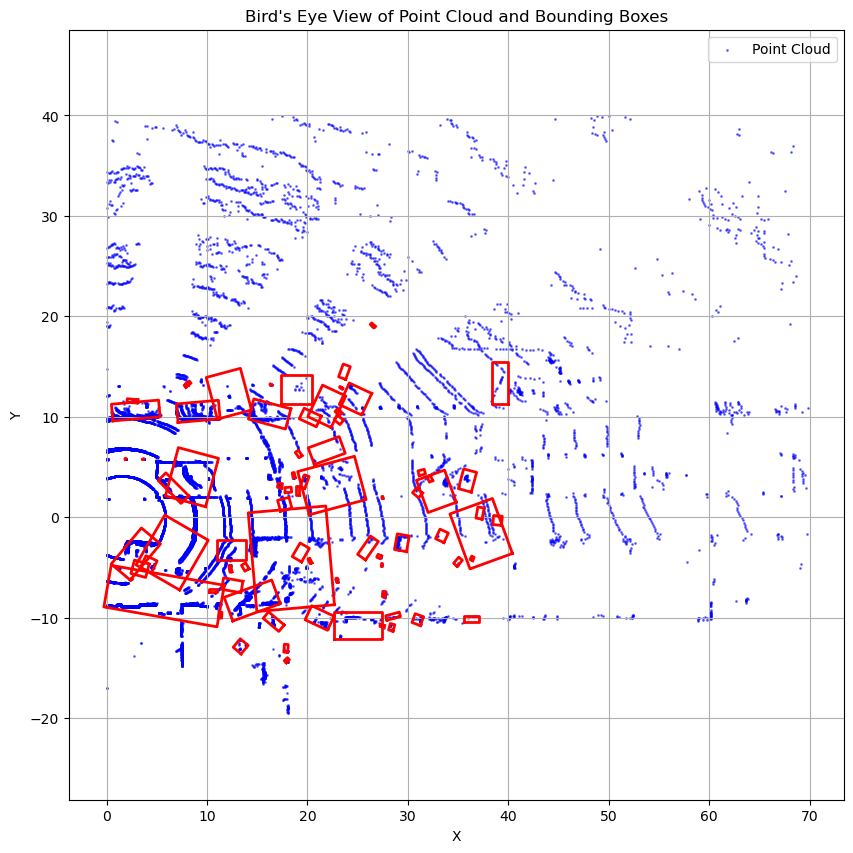

In [340]:
# # Define threshold for normal aspect ratios
# min_normal_ratio = 0.3  # Lower bound (e.g., width at least 30% of length)
# max_normal_ratio = 1.0  # Upper bound (e.g., width at most equal to length)

# # Classify bounding boxes
# bboxes_df['type'] = bboxes_df['aspect_ratio'].apply(
#     lambda ar: 'normal' if min_normal_ratio <= ar <= max_normal_ratio else 'irregular'
# )

# # Separate normal and irregular bounding boxes
# normal_bboxes_df = bboxes_df[bboxes_df['type'] == 'normal']
# irregular_bboxes_df = bboxes_df[bboxes_df['type'] == 'irregular']

def filter_by_aspect_ratio(df, aspect_ratio_col, config):
    """
    Classifies bounding boxes into 'normal' and 'irregular' based on aspect ratio.

    Args:
        df (pd.DataFrame): DataFrame containing bounding box information.
        aspect_ratio_col (str): Column name for aspect ratios in the DataFrame.
        min_ratio (float): Minimum aspect ratio for a bounding box to be classified as 'normal'.
        max_ratio (float): Maximum aspect ratio for a bounding box to be classified as 'normal'.

    Returns:
        pd.DataFrame: Original DataFrame with a new 'type' column indicating 'normal' or 'irregular'.
        pd.DataFrame: Subset of the DataFrame with only 'normal' bounding boxes.
        pd.DataFrame: Subset of the DataFrame with only 'irregular' bounding boxes.
    """
    
    aspect_ratio_filter = config['ASPECT_RATIO_FILTER']
    min_ratio = aspect_ratio_filter['min_ratio']
    max_ratio = aspect_ratio_filter['max_ratio']
    # Classify bounding boxes
    df['type'] = df[aspect_ratio_col].apply(
        lambda ar: 'normal' if min_ratio <= ar <= max_ratio else 'irregular'
    )
    
    # Separate normal and irregular bounding boxes
    normal_bboxes = df[df['type'] == 'normal']
    irregular_bboxes = df[df['type'] == 'irregular']
    
    return df, normal_bboxes, irregular_bboxes

def filter_squares_by_area(df, aspect_ratio_col, area_col,config):
    """
    Filters bounding boxes based on aspect ratio and area thresholds.

    Args:
        df (pd.DataFrame): DataFrame containing bounding box information.
        aspect_ratio_col (str): Column name for aspect ratios in the DataFrame.
        area_col (str): Column name for areas in the DataFrame.
        min_aspect_ratio (float): Minimum aspect ratio for filtering bounding boxes.
        max_area (float): Maximum area for filtering bounding boxes.

    Returns:
        pd.DataFrame: Subset of the DataFrame with bounding boxes that satisfy the conditions.
    """
    square_area_filter = config['AREA_FILTER_SQUARE']
    min_aspect_ratio = square_area_filter['min_aspect_ratio']
    max_area = square_area_filter['square_max_area']
    filtered_df = df[
        (df[aspect_ratio_col] > min_aspect_ratio) &
        (df[area_col] <= max_area)
    ].copy()
    return filtered_df

def filter_rects_by_area(df, aspect_ratio_col, area_col,config):
    # Second filter: Square filter
    rect_area_filter = config['AREA_FILTER_RECT']
    df_square_filtered = df[
        
            (df['aspect_ratio'] <= rect_area_filter['max_aspect_ratio']) &
            (df['area'] <= rect_area_filter['max_area'])
        
    ].copy()
    
    return df_square_filtered

config = {
    "ASPECT_RATIO_FILTER": {
        "min_ratio": 0.3,
        "max_ratio": 1.0
    },
    "AREA_FILTER_SQUARE": {
        "min_aspect_ratio": 0.6,
        "square_max_area": 1.0
    },
    "AREA_FILTER_RECT": {
        "max_aspect_ratio": 0.6,
        "max_area": 50
    },
     "NMS_IOU_THRESHOLD": 0.1,
}

_ , normal_bboxes_df, irregular_bboxes_df = filter_by_aspect_ratio(bboxes_df, 'aspect_ratio', config)
plot_point_cloud_and_bboxes(points_roi[:,:2], bboxes_df_to_numpy_corners(normal_bboxes_df), fig_size=(10,10))
# filtered_bboxes_df = filter_squares_by_area(normal_bboxes_df, 'aspect_ratio', 'area', min_aspect_ratio=0.6, max_area=1.0)

In [341]:
square_filter_df = filter_squares_by_area(normal_bboxes_df, 'aspect_ratio', 'area', config)
rect_filter_df = filter_rects_by_area(normal_bboxes_df, 'aspect_ratio', 'area', config)

combined_df = pd.concat([square_filter_df, rect_filter_df]).drop_duplicates()

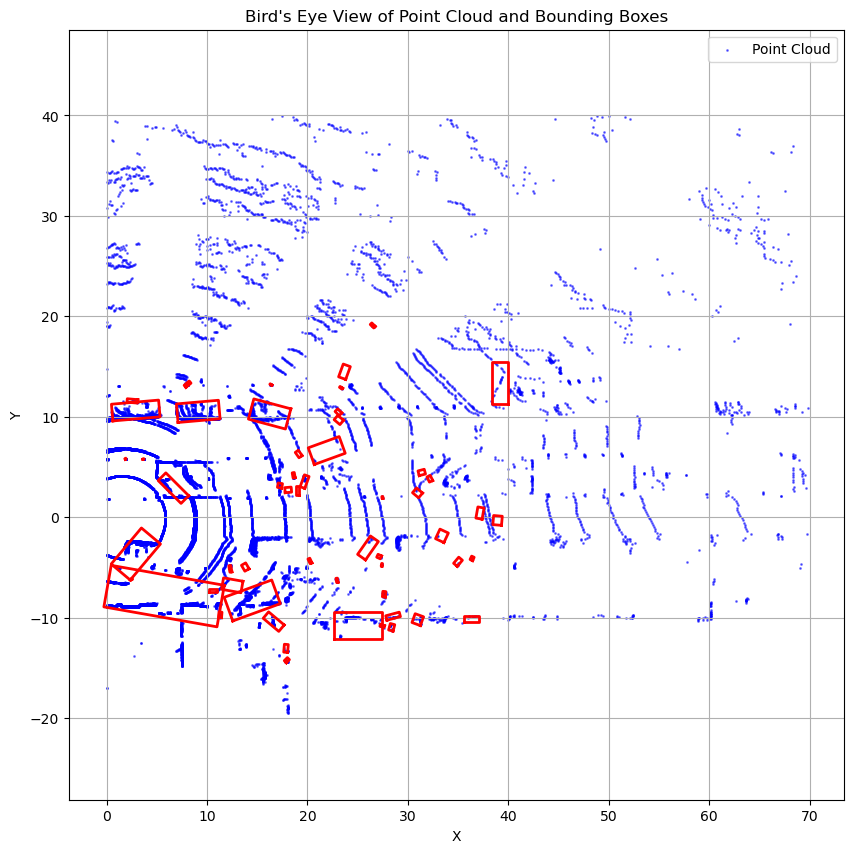

In [342]:
plot_point_cloud_and_bboxes(points_roi[:,:2], bboxes_df_to_numpy_corners(combined_df), fig_size=(10,10))

Statistical filtering

1. remove irregular rectangles => apsect ratio > 0.3

2. remove squares with large area => for all rects > 0.6 area should be less than max_area

Now fiddle around to find out how big max_area should be

array([[<Axes: title={'center': 'area'}>]], dtype=object)

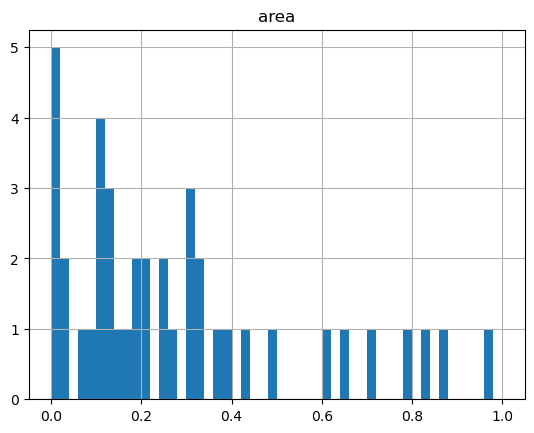

In [343]:
combined_df.hist(column='area', bins=50, range=(0, 1))

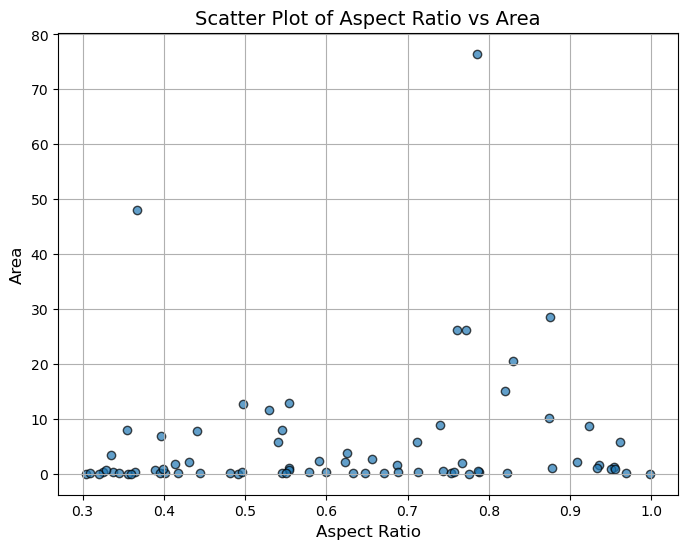

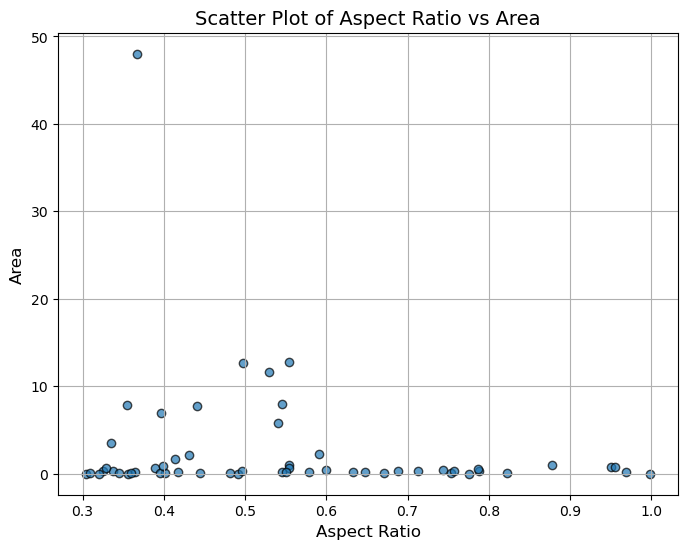

In [344]:
plot_aspect_ratio_vs_area(normal_bboxes_df, 'aspect_ratio', 'area')
plot_aspect_ratio_vs_area(combined_df, 'aspect_ratio', 'area')

So till now we only applied statistical filtering based on area and aspect ratios. 
Now, we apply nms on the filtered bboxes to remove overlapping ones

In [345]:
from typing import List, Tuple
from shapely.geometry import Polygon

def convert_format(boxes_array: np.ndarray) -> Tuple[np.ndarray, List[int]]:
    # boxes_array is a numpy array of shape (N, 4, 2)
    polygons = []
    err_idxs = []
    for idx, box in enumerate(boxes_array):
        try: 
            polygon = Polygon([(point[0], point[1]) for point in box] + [(box[0, 0], box[0, 1])])
            polygons.append(polygon)
        except Exception as e:
            print(f"Error converting bbox at index {idx}: {e}")
            err_idxs.append(idx)
                            
    return np.array(polygons), err_idxs

def compute_iou(box: Polygon, boxes: List[Polygon]):
    """Calculates IoU of the given box with the array of the given boxes.
    Note: the areas are passed in rather than calculated here for efficiency. 
    Calculate once in the caller to avoid duplicate work.
    
    Args:
        box: a polygon (shapely.geometry.Polygon)
        boxes: a numpy array of shape (N,), where each member is a shapely.geometry.Polygon
    Returns:
        a numpy array of shape (N,) containing IoU values
    """
    iou_lst = []
    for b in boxes:
        intersection = box.intersection(b).area
        union = box.union(b).area
        iou = intersection / union if union > 0 else 0
        iou_lst.append(iou)
    return np.array(iou_lst, dtype=np.float32)

def non_max_suppression(boxes: np.ndarray, scores: np.ndarray, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    
    Args:
        boxes: numpy array of shape (N, 4, 2)
        scores: numpy array of shape (N,)    
    
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.

    return an numpy array of the positions of picks
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    polygons, err_idexes = convert_format(boxes)

    top = 64
    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1][:64]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(polygons[i], polygons[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)

    return np.array(pick, dtype=np.int32)


def apply_nms_on_pseudo_labels(corners, nms_iou_threshold) -> Tuple[np.ndarray, np.ndarray]:
    """
    Shape of pred is [N, 4, 2]
    
    Args: 
        pred: a numpy array of shape (N, 4, 2)
    Returns:
        corners: a numpy array of shape (N, 4, 2)
        scores: a numpy array of shape (N,)
    """
    scores = np.ones(corners.shape[0])
    selected_ids = non_max_suppression(corners, scores, nms_iou_threshold)
    corners = corners[selected_ids]
    scores = scores[selected_ids]
    return corners, selected_ids

In [346]:
combined_df.reset_index(drop=True, inplace=True)

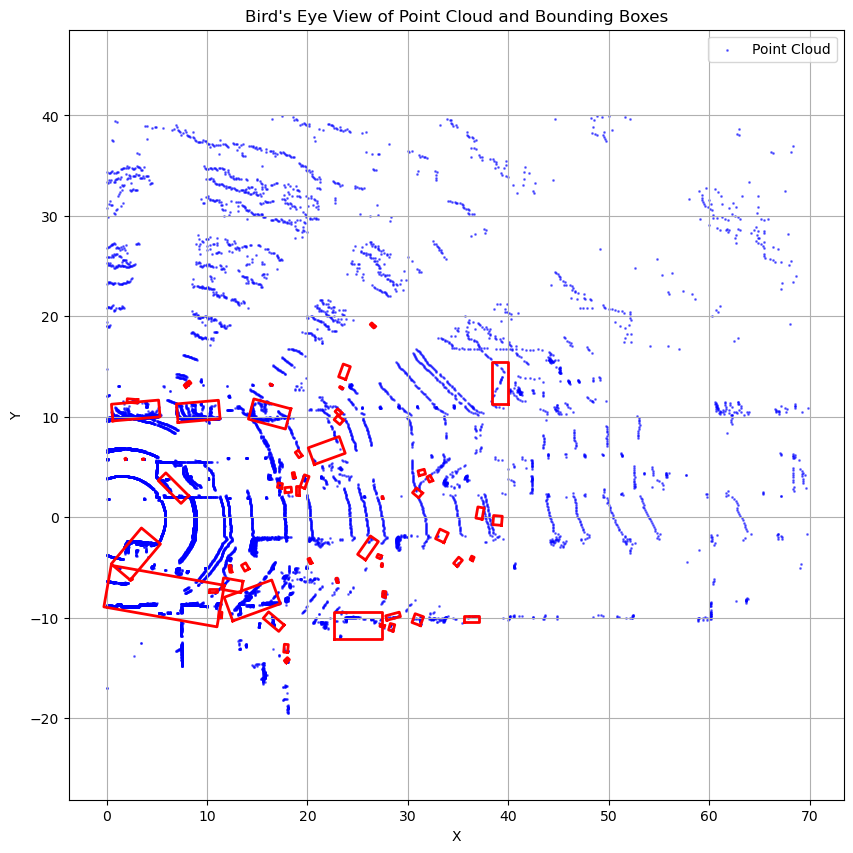

In [347]:
corners, selected_idxes = apply_nms_on_pseudo_labels(bboxes_df_to_numpy_corners(combined_df), config['NMS_IOU_THRESHOLD'])
plot_point_cloud_and_bboxes(points_roi[:,:2], corners, fig_size=(10,10))


In [348]:
selected_idxes

array([54, 13, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 12, 26, 11, 10,
        9,  8,  7,  6,  5,  4,  3,  2,  1, 25, 27, 53, 41, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 40, 28, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29,  0])

In [349]:
# combined_df.reset_index(drop=True, inplace=True)

nms_df = combined_df.iloc[selected_idxes]


Ok now we have all the filtered bboxes, with nms applied on it.  Now we just check, if the nms_df really contains the correct rows. The plot should be similar to the one above, where the corners of nms are visualized

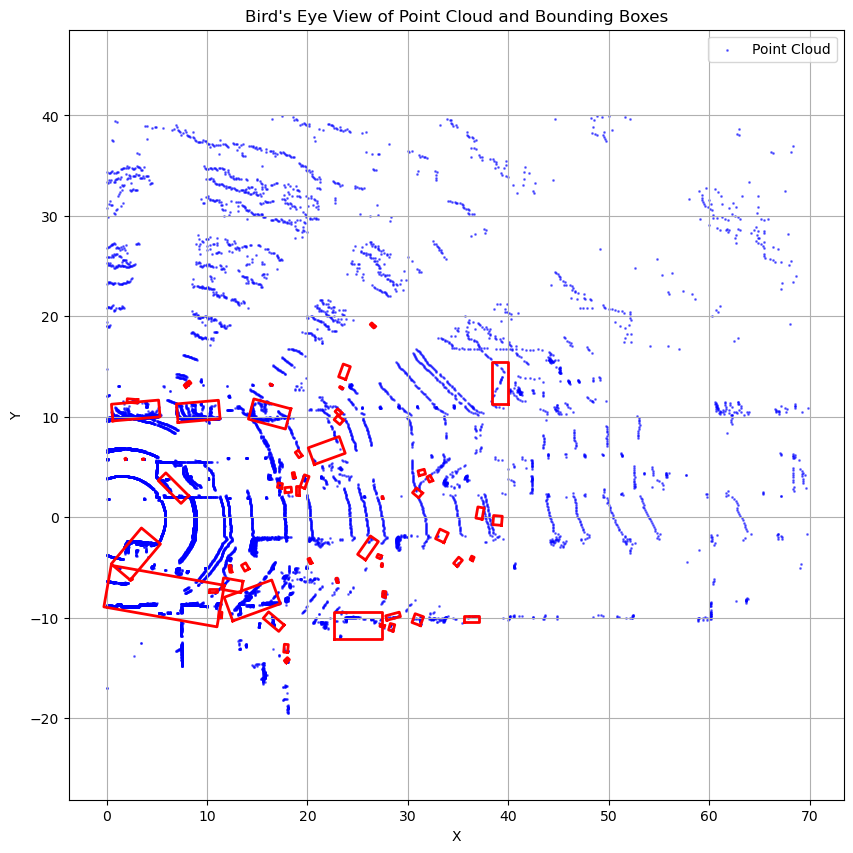

In [350]:
plot_point_cloud_and_bboxes(points_roi[:,:2], bboxes_df_to_numpy_corners(nms_df), fig_size=(10,10))

In [351]:
nms_df.reset_index(drop=True, inplace=True)
nms_df.shape

(55, 8)

In [352]:
bboxes_df.shape
# new_normal_bboxes_df = pd.read_feather(frame_path)
bboxes_df['aspect_area_ratio'] = bboxes_df['aspect_ratio'] * bboxes_df['area']

box_center_x          9.127245
box_center_y         10.536877
box_length            4.200565
box_width             1.853354
ry                    0.087266
aspect_ratio          0.441215
area                  7.785136
type                    normal
aspect_area_ratio     3.434922
Name: 14, dtype: object


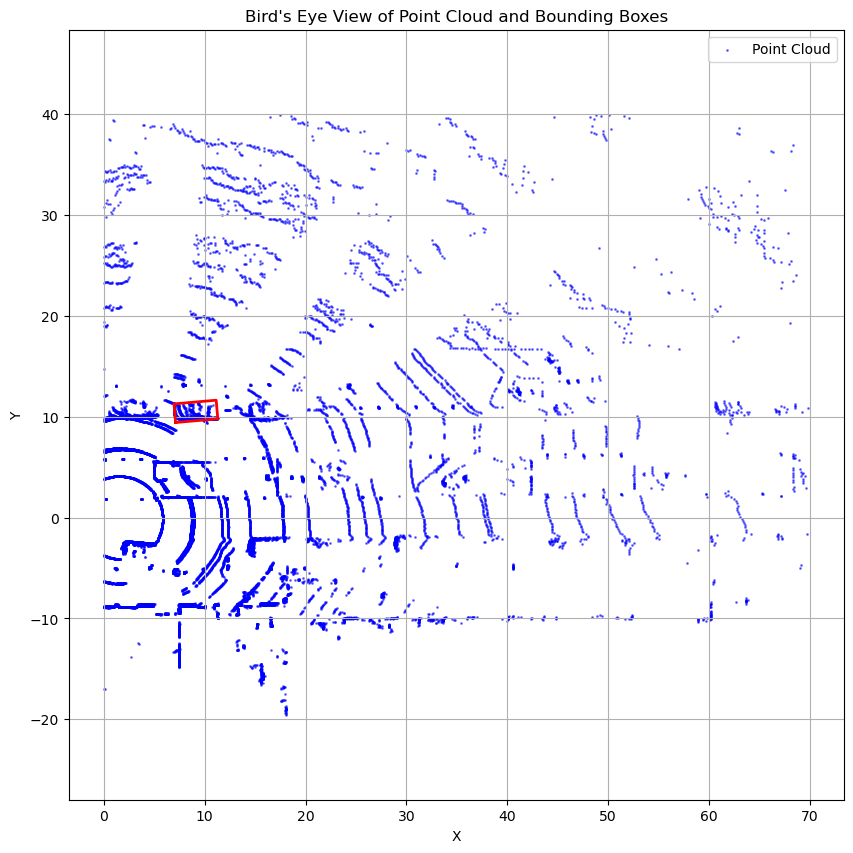

In [371]:
experi_normal_idx = 14
print(bboxes_df.iloc[experi_normal_idx])
box_df = bboxes_df.iloc[experi_normal_idx: experi_normal_idx+1]
normal_box_corners = bboxes_df_to_numpy_corners(box_df)

plot_point_cloud_and_bboxes(points_roi[:,:2],normal_box_corners , fig_size=(10,10))

box_center_x    13.808033
box_center_y    -4.961498
box_length       0.679592
box_width         0.48428
ry               2.094395
aspect_ratio     0.712603
area             0.329113
type               normal
Name: 15, dtype: object


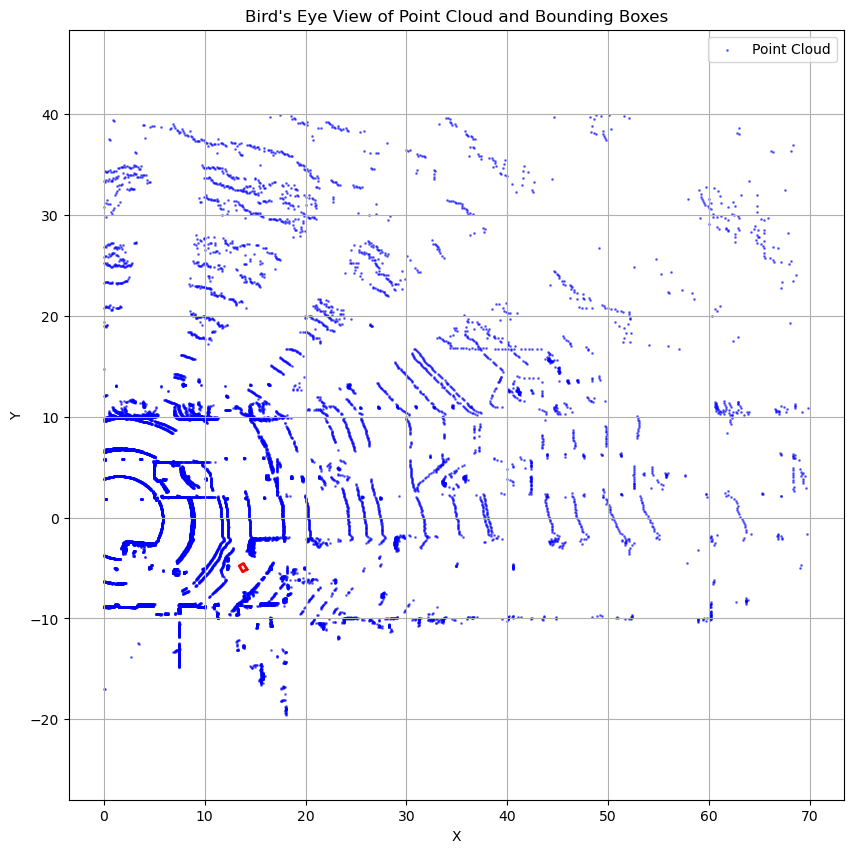

In [354]:
experi_nms_idx = 15

print(nms_df.iloc[experi_nms_idx])
box_df = nms_df.iloc[experi_nms_idx: experi_nms_idx+1]
nms_box_corners = bboxes_df_to_numpy_corners(box_df)

plot_point_cloud_and_bboxes(points_roi[:,:2], nms_box_corners, fig_size=(10,10))